In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


C:\Users\USER\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\USER\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If yo

In [2]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [4]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

In [5]:
import cv2
from PIL import Image
import tf_explain
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [6]:
train_dir = r'C:\Users\USER\Desktop\Ready data\Model_5_resnet152_448\train'
valid_dir = r'C:\Users\USER\Desktop\Ready data\Model_5_resnet152_448\vaild1'


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  
)


valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  
)




train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(448, 448),
    class_mode='categorical',
    shuffle=True
)


valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(448, 448),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)




Found 9395 images belonging to 7 classes.
Found 1117 images belonging to 7 classes.


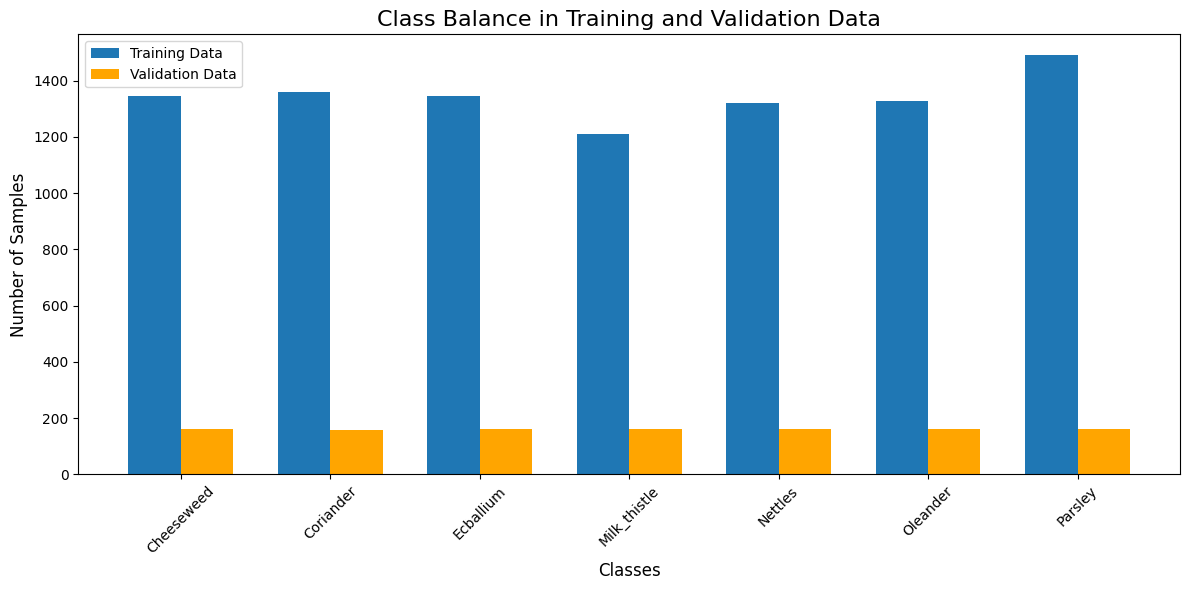

In [7]:



train_class_counts = np.bincount(train_generator.classes)
valid_class_counts = np.bincount(valid_generator.classes)


class_labels = list(train_generator.class_indices.keys())


plt.figure(figsize=(12, 6))
bar_width = 0.35  


plt.bar(
    np.arange(len(class_labels)) - bar_width / 2,
    train_class_counts,
    bar_width,
    label="Training Data"
)


plt.bar(
    np.arange(len(class_labels)) + bar_width / 2,
    valid_class_counts,
    bar_width,
    label="Validation Data",
    color='orange'
)


plt.title("Class Balance in Training and Validation Data", fontsize=16)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45, fontsize=10)
plt.legend()
plt.tight_layout()


plt.show()


In [8]:

base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(448, 448, 3) )


x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)  
#x = BatchNormalization()(x)
x = LayerNormalization()(x)
x = Dropout(0.5)(x) 

x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)  
#x = BatchNormalization()(x)
x = LayerNormalization()(x)
x = Dropout(0.5)(x)


predictions = Dense(7, activation='softmax', kernel_regularizer=l2(1e-4))(x)


model = Model(inputs=base_model.input, outputs=predictions)

#### Freeze all layers in the base model

In [9]:
for layer in base_model.layers:
    layer.trainable = False



model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



#### Unfreeze the last few layers of the base model

In [10]:
for layer in base_model.layers[-10:]:  
    layer.trainable = True

#CategoricalCrossentropy(label_smoothing=0.1)
#  loss='categorical_crossentropy'

#optimizer = Adam(learning_rate=1e-4, decay=1e-6)
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['accuracy'])


#### Model Summary

In [11]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 454, 454, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 224, 224, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)


class_weights = dict(enumerate(class_weights_array))


print(class_weights)

{0: 0.9986181972789115, 1: 0.9875959213707558, 2: 0.9978757302177377, 3: 1.110126432707078, 4: 1.0152366544197104, 5: 1.0121741004093945, 6: 0.9007670182166826}


In [57]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]



history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=200,
    callbacks=callbacks,
    class_weight=class_weights
    
)



Epoch 1/200
294/294 [==============================] - ETA: 0s - loss: 1.0112 - accuracy: 0.6829
Epoch 1: val_loss improved from inf to 0.66041, saving model to best_model.h5
294/294 [==============================] - 40s 114ms/step - loss: 1.0112 - accuracy: 0.6829 - val_loss: 0.6604 - val_accuracy: 0.8111 - lr: 1.0000e-04
Epoch 2/200
294/294 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.9180
Epoch 2: val_loss did not improve from 0.66041
294/294 [==============================] - 30s 103ms/step - loss: 0.3266 - accuracy: 0.9180 - val_loss: 0.6821 - val_accuracy: 0.8397 - lr: 1.0000e-04
Epoch 3/200
294/294 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9692
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 3: val_loss did not improve from 0.66041
294/294 [==============================] - 30s 103ms/step - loss: 0.1752 - accuracy: 0.9692 - val_loss: 0.6787 - val_accuracy: 0.8514 - lr: 1.0000e-04
Epoch 4

### Test

In [58]:
test_dir = r'C:\Users\USER\Desktop\Ready data\test'



test_datagen = ImageDataGenerator(
    
    preprocessing_function=preprocess_input  
)





test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(448, 448),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)



Found 157 images belonging to 7 classes.


In [59]:

val_loss, val_accuracy = model.evaluate(valid_generator, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



35/35 [==============================] - 3s 89ms/step - loss: 0.6604 - accuracy: 0.8111
Validation Loss: 0.6604059934616089
Validation Accuracy: 0.8111011385917664
5/5 [==============================] - 1s 160ms/step - loss: 0.6486 - accuracy: 0.8153
Test Loss: 0.6485658288002014
Test Accuracy: 0.8152866363525391


# Vaildation matrix

In [41]:
true_classes = valid_generator.classes  

class_labels = list(valid_generator.class_indices.keys())  #





In [42]:
predictions = model.predict(valid_generator)


predicted_classes = np.argmax(predictions, axis=1)






10/10 [==============================] - 4s 160ms/step


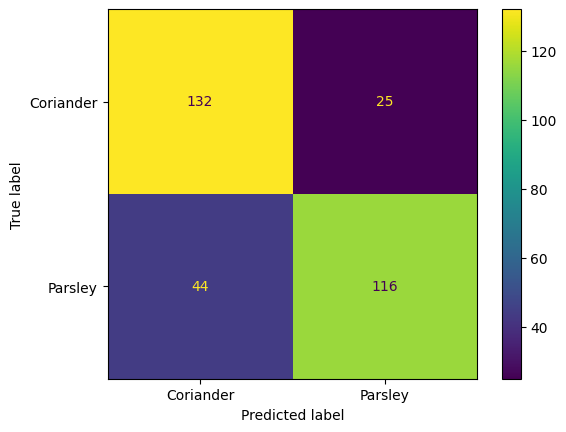

In [43]:



cm = confusion_matrix(true_classes, predicted_classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='viridis', values_format='d')




# Test matrix

In [44]:
true_classes = test_generator.classes  

class_labels = list(test_generator.class_indices.keys())  





In [45]:
predictions = model.predict(test_generator)


predicted_classes = np.argmax(predictions, axis=1)






2/2 [==============================] - 1s 1s/step


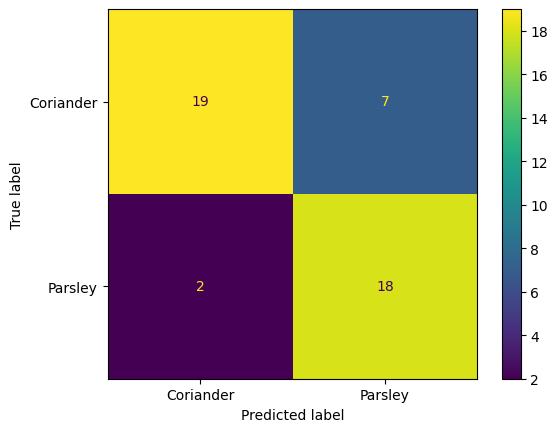

In [46]:



cm = confusion_matrix(true_classes, predicted_classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='viridis', values_format='d')


